This notebook demonstrates the principal supported 1D advection operators in FV3, applied to a couple of different initial conditions, advected on a periodic domain of length `nx` for a certain length of time, either 4x times around the domain or for a few timesteps. All schemes use the Piecewise-Parabolic Method with a variety of constraints. 

This is intended to be an **interactive** notebook; see the options given in cell \#2. It is fully self-contained so you can download and play as you would like. 

In [1]:
#Libraries
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import matplotlib.ticker as ticker

In [2]:
#User Options

#Solver
ord = 5 # 5, 6, 8, 10 
PD = False #Positivity constraint for ord = 5, 6
dt = 1
courant = 0.8 #PPM is formally stable for courant on [0,1]

#Initial conditions: 
# 0 is a Gaussian of width 5
# 1 is a top-hat (discontinuous) profile of width 3
# 2 is like 1 with a 2dx signal superposed
tracer_type = 0

#Grid
nx = 40
dx = 1.0
L = nx*dx
dxa = dx*np.ones(nx)
xi = np.concatenate((np.array([0]), np.cumsum(dxa)))
xc = 0.5*(xi[1:]+xi[:-1])

#Integration length
c0 = courant*dx/dt
tend = np.ceil(L/c0*4) # 4 times around
#tend = 10.*dt #10 timesteps 

#Zoom area
zoomL = 20
zoomR = 30

#Figure dir
writeFigs=False
figdir='./tp_core_figures/' #Must exist

In [3]:
#From https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
## CAUTION annoyingly slow webpage
large = 18; med = 16; small = 14
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)

In [4]:
#Constants
c1 = -2./14. ; c2 = 11./14. ; c3 = 5./14.
p1 = 7./12. ; p2 = -1./12.
r12 = 1./12. ; r3 = 1./3.

In [5]:
#Define indices with periodicity built-in
ix = np.arange(nx)
ixp1 = np.mod((ix + 1), nx)
ixm1 = np.mod((ix - 1), nx)
ixm2 = np.mod((ix - 2), nx)

#Interface indices with periodicity
hx = np.mod(np.arange(nx+1), nx)
hxm1 = np.mod(hx-1,nx)

In [6]:
#Define analytic profiles

def wrap_around(xc,L):
    xw = np.mod(xc,L)
    return xw

#IC #0
#Assumes domain is L = 40 wide
def tracer_gaussian(xc):
    xw = wrap_around(xc,L)
    x0 = L/2.
    width = 5.
    q = np.exp(-(xw-x0)*(xw-x0)/width/width)
    return q

#IC #1
def tracer_tophat(xc):
    xw = wrap_around(xc,L)
    x0 = L/2.
    width = 3.
    q = np.zeros(nx)
    q[np.where(np.logical_and(xw > x0-width,xw < x0+width))] = 1.
    return q

#IC #2
def tracer_2dx_tophat(xc):
    xw = wrap_around(xc,L)
    q = tracer_tophat(xc)*0.75
    i2 = np.where(q > 0)
    q[i2] = q[i2] + 0.1*np.sin(np.pi*xc[i2])
    return q

def method_string():
    outstr = 'hord = ' + str(ord)
    if PD and ord < 7:
        outstr += ', positive-definite'
    return outstr

In [7]:
if tracer_type == 1:
    tracer_init = tracer_tophat
elif tracer_type == 2:
    tracer_init = tracer_2dx_tophat
else:
     tracer_init = tracer_gaussian   

Below is the loop that advances the solution and makes plots. The exact solution is given in red and the computed solution is given in blue.

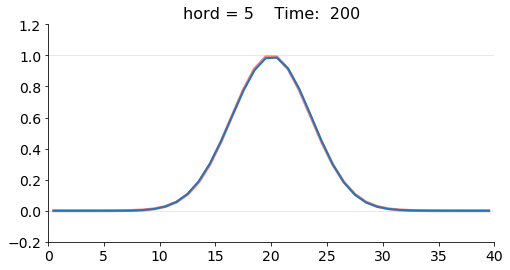

In [8]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1) 
time = 0
q = tracer_init(xc)
c = c0*np.ones(nx+1)
#plt.ion()

title_str = method_string() + '    Time: %4d'

#Integration loop
while time < tend:
#c = dt*u/dxa; taken as a variable; defined on cell../common/diag_table_pire_reduced interfaces
#Ignoring edge handling for now

    #begin xppm
       
    #al, c defined on interfaces
    #q, bl, br, b0, smt5 defined on cells

    qprev = q
    
    if ord < 7:
        al = p1*(q[ixm1]+q[ix]) + p2*(q[ixm2]+q[ixp1]) #std for all PPM
        if PD:
            al[np.where(al < 0.)] = 0.

        bl = al[ix] - q[ix]
        br = al[ixp1] - q[ix]
        b0 = br + bl

        #Slight difference from tp_core for graphical purpose:
        # in S-J's code smt5 is False if bl = br = 0, in which
        # case the reconstruction is piecewise-constant anyway.
        # This is for efficiency (no reason to evaluate higher-
        # order flux when it naturally is first-order)
        # To show places where the limiter is actually working
        # we set smt5 = true if recon is naturally flat.
        if ord == 1:
            smt5 = np.abs(lim_fac*b0) <= np.abs(bl-br)
        elif ord == 6:
            smt5 = 3.*np.abs(b0) <= np.abs(bl-br)
        else:
            smt5 = br*bl <= 0

        if PD:
            da1 = br - bl
            a4 = -3*b0

            cond1 = (np.abs(da1) < -a4) & (q + 0.25/a4*da1*da1 + a4*r12 < 0.)
            icond2 = np.where(cond1 & ~smt5)
            icond3 = np.where(cond1 & smt5 & (da1 > 0.))
            icond4 = np.where(cond1 & smt5 & (da1 <= 0.))

            br[icond2] = 0.
            bl[icond2] = 0.
            b0[icond2] = 0.

            br[icond3] = -2.*bl[icond3]
            b0[icond3] =    -bl[icond3]

            bl[icond4] = -2.*br[icond4]
            b0[icond4] =    -br[icond4]
    else:
        xt = 0.25*(q[ixp1] - q[ixm1])
        nearstack = np.stack((q[ix],q[ixm1],q[ixp1]))
        dm = np.sign(xt)*np.min( np.stack( ( np.abs(xt), np.max(nearstack,axis=0)-q, q-np.min(nearstack,axis=0))), axis=0)
        al = 0.5*(q[ixm1]+q[ix]) + r3*(dm[ixm1]-dm[ix])
        
        if ord == 8:
            xt = 2.*dm
            bl = -np.sign(xt)*np.min( np.stack(( np.abs(xt), np.abs(al[ix]  -q[ix] ))), axis=0)
            br =  np.sign(xt)*np.min( np.stack(( np.abs(xt), np.abs(al[ixp1]-q[ix] ))), axis=0)
        else:
            dq = 2.*(q[ixp1] - q[ix])
            bl = al[ix] - q[ix]
            br = al[ixp1] - q[ix]

            cond1 = np.abs(dm[ixm1]) + np.abs(dm[ix]) + np.abs(dm[ixp1]) < 1.e-25
            cond2 = np.abs(3.*(bl+br)) > np.abs(bl-br) 

            icond1 = np.where(cond1)
            bl[icond1] = 0.
            br[icond1] = 0.
            
            icond2 = np.where(cond2 & ~cond1)

            pmp2 = dq[ixm1[icond2]]
            lac2 = pmp2 - 0.75*dq[ixm2[icond2]]
            dd21 = np.max( np.stack((pmp2*0,pmp2,lac2)), axis=0)
            dd22 = np.min( np.stack((pmp2*0,pmp2,lac2)), axis=0)
            dd22 = np.max( np.stack((br[icond2],dd22)), axis=0)
            br[icond2] = np.min( np.stack((dd21,dd22)), axis=0)

            pmp1 = -dq[ix[icond2]]
            lac1 = pmp1 + 0.75*dq[ixp1[icond2]]
            dd11 = np.max( np.stack((pmp1*0,pmp1,lac1)), axis=0)
            dd12 = np.min( np.stack((pmp1*0,pmp1,lac1)), axis=0)
            dd12 = np.max( np.stack((bl[icond2],dd12)), axis=0)
            bl[icond2] = np.min( np.stack((dd11,dd12)), axis=0)

        b0 = bl+br

    #compute flux
    up = np.where(c > 0)[0]
    ixup = np.mod(np.arange(nx+1),nx)
    ixup[up] = ixup[up]-1
    
    cup = c.copy()
    cup[up] = -c[up]

    brl = bl[ixup]
    brl[up] = br[ixup[up]]
    
    fx1 = (1.+cup)*(brl + cup*b0[ixup])
    flux = q[ixup].copy()
    
    if ord <= 7:
        lfull = np.logical_or(smt5[hx], smt5[hxm1])
        full = np.where(lfull)[0]
        flat = np.where(np.logical_not(lfull))[0]
        flux[full] = flux[full] + fx1[full]
    else:
        full = range(nx+1)
        flat = []
        flux = flux + fx1
    
    flux = flux*c     

    q = q + (flux[:-1] - flux[1:])
    time += dt
    
    #https://medium.com/@shahinrostami/jupyter-notebook-and-updating-plots-f1ec4cdc354b
    ax.cla()
    
    #Background lines
    xi0 = xi*0.0
    ax.plot(xi,xi0,color='lightgray',linewidth=0.5)
    ax.plot(xi,xi0+1.0,color='lightgray',linewidth=0.5)
    
    
    ax.plot(xc,tracer_init(xc - c0*(time)), linewidth=3, color='r', alpha=0.5) #exact solution
    ax.plot(xc, q, linewidth=2) #Current value
    ax.set_ylim((-0.2,1.2))
    ax.set_xlim((xi[0],xi[-1]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.set_title(title_str % (time))
    display(fig)
    clear_output(wait = True)
    
    
if writeFigs:
    fig.savefig('/'.join((figdir, f'hord{ord}{PD}_IC{tracer_type}_time{time}_plot.png')))

The next figure plots the sub-grid reconstructions in addition to the solution at the end of the simulation.  The colors indicate:
- Black: reconstruction
- Red: filtered reconstruction: the plotted reconstruction has been replaced with a first-order (flattened) reconstruction for computing the upwind flux.
- Green: A reconstruction which has been modified to enforce positivity.
- Purple and orange: limited reconstructions from the Huynh conditions (hord = 10)

You can see some interesting things by running just a few timesteps, to see how schemes try to handle different ICs.

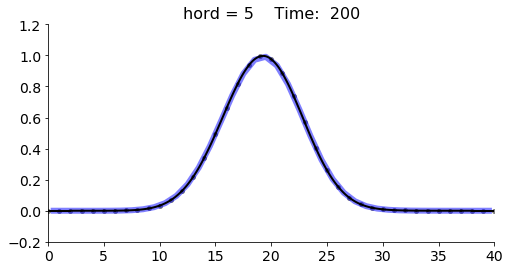

In [9]:
#Note that the reconstructions need not be continuous!!
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1) 
#Reconstruction plotting: in-cell coordinate is zz
Nzz = 10 + 1
zz = np.linspace(-1.,0.0,Nzz)
zz = np.tile(zz,(nx+1,1))
zp = (zz.T + np.reshape(xi, (1,nx+1))).T + 1.0

A = np.reshape(qprev[hx] + br[hx], (nx+1,1)) 
B = 2.*np.reshape(2.*br[hx]+bl[hx], (nx+1,1))
C = 3.*np.reshape(b0[hx], (nx+1,1))
recon = A + (zz)*(B + C*(zz))
        
plt.plot(xc,qprev,color='blue',linewidth=6,alpha=0.5)
#plt.plot(zp.T,recon.T,color='black');
plt.scatter(xi,al[hx],color='gray',marker='o',s=15)
plt.plot(zp[full,:].T,recon[full,:].T,color='black',linewidth=2);
plt.plot(zp[flat,:].T,recon[flat,:].T,color='red',linewidth=2);
if PD and ord < 7:
    cond1a = np.append(cond1,cond1[0])
    plt.plot(zp[cond1a,:].T,recon[cond1a,:].T,color='limegreen',linewidth=3)
if ord == 10:
    #Plot conditions
    cond1a = np.append(cond1,cond1[0])
    cond2a = np.append(cond2,cond2[0])
    plt.plot(zp[cond1a,:].T,recon[cond1a,:].T,color='purple',linewidth=3)
    plt.plot(zp[cond2a,:].T,recon[cond2a,:].T,color='orange',linewidth=3)
    
    
plt.gca().set_ylim((-0.2,1.2))
plt.gca().set_xlim((xi[0],xi[-1]))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title(title_str % (time));

    
if writeFigs:
    fig.savefig('/'.join((figdir, f'hord{ord}{PD}_IC{tracer_type}_time{time}_recons.png')))

This plot zooms in on the reconstructions to also show the edge values (green and purple triangles). Additionally the unlimited edge values are shown for the monotonic hord = 8 scheme. The zoom area can be configured (see zoomL and zoomR in cell \#2 above).

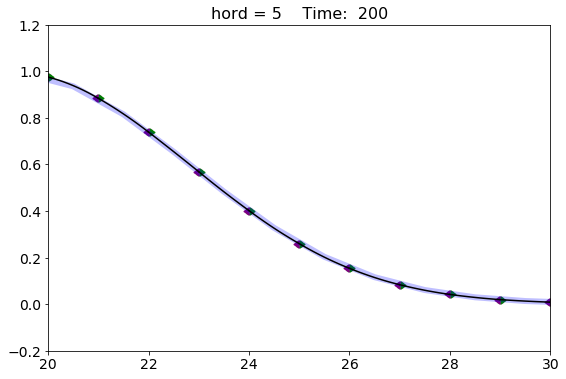

In [10]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1) 

#Zoom-in
zL=zoomL
zR=zoomR

plt.plot(xc,qprev,color='blue',linewidth=6,alpha=0.25)
#plt.plot(zp.T,recon.T,color='black');
plt.scatter(xi,al[hx],color='gray',marker='o',s=50)
plt.plot(zp[full,:].T,recon[full,:].T,color='black',markersize=2);
plt.plot(zp[flat,:].T,recon[flat,:].T,color='red',markersize=2);
plt.scatter(xi[:-1],bl+qprev,marker=9,color='g',s=50)
plt.scatter(xi[1:],br+qprev,marker=8,color='purple',s=50)
if ord==8:
    plt.errorbar(xi[:-1]+0.05,qprev[ix],yerr=xt,fmt='none',capsize=4,color='g',alpha=0.5)
    plt.errorbar(xi[1:]-0.05,qprev[ix],yerr=xt,fmt='none',capsize=4,color='purple',alpha=0.5)
    

ax.set_xlim((xi[zL],xi[zR]));
ax.set_ylim((-0.2,1.2));
ax.set_title(title_str % (time));
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

if writeFigs:
    fig.savefig('/'.join((figdir, f'hord{ord}{PD}_IC{tracer_type}_time{time}_zoom{zL}-{zR}.png')))